In [3]:
from PIL import Image
import numpy as np
import scipy.ndimage
import random
import time
from skimage.feature import hog

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Open images in Pillow, resize if needed
desert=Image.open('/content/drive/MyDrive/Seam_Carving_Project/desert.jpg')
desert.thumbnail((500,500))
tower = Image.open('/content/drive/MyDrive/Seam_Carving_Project/tower.jpg')
tower = tower.resize((200,135))
fish = Image.open('/content/drive/MyDrive/Seam_Carving_Project/fish.jpg')
fish = fish.resize((250,120))
dolphin = Image.open('/content/drive/MyDrive/Seam_Carving_Project/dolphin.jpg')
dolphin.thumbnail((500,500)) 
arc = Image.open('/content/drive/MyDrive/Seam_Carving_Project/arc.jpg')
wave = Image.open('/content/drive/MyDrive/Seam_Carving_Project/wave_painting.jpg')
wave2 = Image.open('/content/drive/MyDrive/Seam_Carving_Project/wave_painting2.jpg') 
big_painting = Image.open('/content/drive/MyDrive/Seam_Carving_Project/big_painting.jpg') 
big_painting.thumbnail((500,500)) 
row = Image.open('/content/drive/MyDrive/Seam_Carving_Project/rowboat.jpg') 
row.thumbnail((500,500)) 
dali = Image.open('/content/drive/MyDrive/Seam_Carving_Project/dali.jpg') 
dali.thumbnail((500,500)) 
jump = Image.open('/content/drive/MyDrive/Seam_Carving_Project/paris_jump.jpg') 
jump.thumbnail((500,500)) 
students = Image.open('/content/drive/MyDrive/Seam_Carving_Project/hopkins_students.jpg') 
students.thumbnail((500,500)) 
jhu = Image.open('/content/drive/MyDrive/Seam_Carving_Project/jhu_2022.jpg') 
jhu.thumbnail((500,500)) 
dolphinJ = Image.open('/content/drive/MyDrive/Seam_Carving_Project/dolphin_jump.jpg')
dolphinJ.thumbnail((500,500)) 
pond = Image.open('/content/drive/MyDrive/Seam_Carving_Project/pond_painting.jpg')
pond.thumbnail((500,500)) 
bird = Image.open('/content/drive/MyDrive/Seam_Carving_Project/bird_painting.jpg')
bird.thumbnail((500,500)) 
city = Image.open('/content/drive/MyDrive/Seam_Carving_Project/city.jpg')
city.thumbnail((500,500)) 
dante = Image.open('/content/drive/MyDrive/Seam_Carving_Project/dante.jpg')
dante.thumbnail((500,500)) 

In [5]:
def get_average_energy(img):
  """
  Calculates average L1-Norm energy acorss all pixels
  :param img: a 2D image array
  :return: scalar representing average energy
  """ 
  energy = get_energy(img)
  return np.average(energy)

def viz_energy(en):
  """
  Visualizes Energy Function
  :param en: the output of an energy function
  """ 
  en = 255*(((en - en.min()) / (en.max() - en.min()))) #rescale to [0,255]
  display(Image.fromarray(en.astype(np.uint8)))

def get_energy(img):
  """
  Calculates L1-Norm Energy Function
  :param img: a 2D image array
  :return: a pixel-wise energy map
  """ 
  hy = (1/8)*np.array([[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]])
  hx = (1/8)*np.array([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]])
  dx = scipy.ndimage.convolve(img, hx, mode='constant')
  dy = scipy.ndimage.convolve(img, hy, mode='constant')
  energy = np.abs(dx) + np.abs(dy)
  return energy

def get_energy_L2(img):
  """
  Calculates L2-Norm Energy Function
  :param img: a 2D image array
  :return: a pixel-wise energy map
  """ 
  hx = (1/8)*np.array([[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]) #Sobel filter
  hy = (1/8)*np.array([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]])
  dx = scipy.ndimage.convolve(img, hx, mode='constant')
  dy = scipy.ndimage.convolve(img, hy, mode='constant')
  
  energy = (np.square(dx) + np.square(dy))**(1/2)
  return energy

def gaussianKernelGenerator(n=5, sigma = 1/(2**0.5)):
  """
  Generates a gaussian smoothing kerenl
  :param n: the kernel size
  :param sigma: the standard deviation of the gaussian
  :return: a guassian smoothing kernel
  """ 
  xSpace = np.linspace(-(n - 1)/2, (n - 1)/2, n)
  gauss1d = np.exp(-0.5 * np.square(xSpace) / np.square(sigma))
  gaussianKernel = np.outer(gauss1d, gauss1d)
  return gaussianKernel / np.sum(gaussianKernel)

def get_energy_harris(img, gaussianQ = False, kernelSize = 2, sigma = 1/(2**0.5)):
  """
  Calculates Harris Corner Detector Energy Function
  :param img: a 2D image array
  :param gaussianQ: True if Guassian Kernel is used
  :param kernelSize: the window size will be (kernelSize*2)+1
  :param sigma: standard deviation for the Gaussian Kernel if used
  :return: a pixel-wise energy map
  """ 
  hy = (1/8)*np.array([[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]) #Sobel filter
  hx = (1/8)*np.array([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]])
  Ix = scipy.ndimage.convolve(img, hx, mode='constant')
  Iy = scipy.ndimage.convolve(img, hy, mode='constant')
  kernel = np.ones((2*kernelSize + 1, 2*kernelSize + 1))

  if gaussianQ == True:
    kernel = gaussianKernelGenerator(kernelSize * 2 + 1, sigma)

  Ix2 = np.square(Ix)
  Iy2 = np.square(Iy)
  Ixy = Ix * Iy

  Ix2_sum = scipy.ndimage.convolve(Ix2, kernel, mode='constant')
  Iy2_sum = scipy.ndimage.convolve(Iy2, kernel, mode='constant')
  Ixy_sum = scipy.ndimage.convolve(Ixy, kernel, mode='constant')
  
  alpha = 0.04
  determinant = Ix2_sum * Iy2_sum - np.square(Ixy_sum)
  trace = Ix2_sum + Iy2_sum
  energy = determinant - alpha * np.square(trace)
  return energy

def get_energy_HoG(img):
  """
  Calculates HoG Energy Function
  :param img: a 2D image array
  :return: a pixel-wise energy map
  """ 
  numerator = get_energy(img)
  hog_array, hog_image = hog(img, orientations=8, pixels_per_cell=(11, 11),
                    cells_per_block=(1, 1), visualize=True, feature_vector=True, multichannel=False)
  
  hog_max = np.amax(hog_array)
  energy = numerator/hog_max
  return energy

def create_seams(oldImage, energyType=0):
  """
  Creates seams using dynamic programming
  :param oldImage: a 2D image array
  :param energyType: integer corresponding to an energy function, 
                      0=L1, 1=L2, 2=Harris, 3=HoG
  :return: array of ordered pairs of form (cumulative energy, parent index)
  """ 
  dp = np.empty(shape=oldImage.shape, dtype="f,f") #array of ordered pairs
  if energyType == 0:
    energy = get_energy(oldImage) #L1 Energy
  elif energyType == 1:
    energy = get_energy_L2(oldImage) #L2 Energy
  elif energyType == 2:
    energy = get_energy_harris(oldImage) #Harris Detector Energy
  elif energyType == 3:
    energy = get_energy_HoG(oldImage) #HoG Energy
  else:
    energy = get_energy(oldImage)

  for x in range(energy.shape[0]):
      for y in range(energy.shape[1]):
          if x == 0: dp[x,y] = (energy[x,y],-1)
          elif y == 0:
              vals = [dp[x-1,y][0], dp[x-1,y+1][0]]
              i = np.argmin(vals) 
              #assign ordered pair (cumulative energy, parent index)
              dp[x,y] = (energy[x,y] + vals[i], y + i) 
          elif y == (energy.shape[1] - 1): 
              vals = [dp[x-1,y][0], dp[x-1,y-1][0]]
              i = np.argmin(vals)
              #assign ordered pair (cumulative energy, parent index)
              dp[x,y] = (energy[x,y] + vals[i], y - i)
          else:
              vals = [dp[x-1,y-1][0], dp[x-1,y][0], dp[x-1,y+1][0]]
              i = np.argmin(vals)
              #assign ordered pair (cumulative energy, parent index)
              dp[x,y] = (energy[x,y] + vals[i], y + i - 1)
  return dp

def find_seam(dp):
  """
  Finds the seam with the lowest cumulative energy
  :param dp: an array of ordered pairs of form (cumulative energy, parent index)
  :return: list of column indices in the seam, shape of image
  """ 
  minVal, minIndex = float('inf'), -1
  #find argmin of bottom row
  for i in range(dp.shape[1]):
      if dp[-1,i][0] < minVal:
          minVal = dp[-1,i][0]
          minIndex = i
  path = [minIndex]
  #backtrack up to the top row
  for i in range(dp.shape[0]-1)[::-1]: path.append(dp[i,int(path[-1])][1])
  return path[::-1], dp.shape

def remove_seam(path, oldImage, oldColorImage, shape, coords=None):
  """
  Removes the seam from the image
  :param path: list of column indices in the seam
  :param oldImage: a 2D image array
  :param oldColorImage: a 3D color image array
  :param shape: the spatial dimensions of oldImage
  :param coords: an array of coordimate value, only used for enlarging
  :return: returns the shrunken 2D image, shrunken 3D image, 
            and the coordinates of the surviving pixels in 
            the original coordinate space
  """ 
  #initialize new arrays
  newImage = np.zeros((shape[0],shape[1]-1))
  newColorImage = np.zeros((shape[0],shape[1]-1,3))
  newCoords = np.zeros((shape[0],shape[1]))

  #copy over pixels, skipping pixels in the seam
  for x in range(newImage.shape[0]):
      skipped = 0
      for y in range(newImage.shape[1]):
          if y == path[x]: skipped = 1
          newImage[x,y] = oldImage[x,y+skipped]
          newColorImage[x,y,:] = oldColorImage[x,y+skipped,:]
          if coords is not None: newCoords[x,y] = coords[x,y+skipped]
  return newImage, newColorImage, newCoords

def seam_carve(img, h_reduce=0.0, v_reduce=0.0, energyType=0):
  """
  Shrinks an image using seam carving
  :param img: A Pillow Image
  :param h_reduce: a value in (0,1) denoting the proportion of the 
                    horizontal dimension which should be removed
  :param v_reduce: a value in (0,1) denoting the proportion of the 
                    vertical dimension which should be removed
  :param energyType: integer corresponding to an energy function, 
                      0=L1, 1=L2, 2=Harris, 3=HoG
  :return: the shrunken 2D and 3D image
  """ 
  #process input
  colorImage = np.asarray(img)
  image = np.asarray(img.convert("L")).astype('float64')
  numRemoveH = int(h_reduce*image.shape[1]) 
  numRemoveV = int(v_reduce*image.shape[0])

  for i in range(numRemoveH):
    t1 = time.time() #start time
    dp = create_seams(image, energyType)
    path, shape = find_seam(dp)
    image, colorImage, _ = remove_seam(path, image, colorImage, shape)
    t2 = time.time() #stop time
    tRemaining = ((t2-t1)*(numRemoveH+numRemoveV-i))/60 #estimate time remaining
    if i % 20 == 0: 
      print('Carving Time Remaining: ' + str(tRemaining) + ' minutes')
  image, colorImage =  np.rot90(image), np.rot90(colorImage) #rotate images
  for i in range(numRemoveV): 
    t1 = time.time() #start time
    dp = create_seams(image, energyType)
    path, shape = find_seam(dp)
    image, colorImage, _ = remove_seam(path, image, colorImage, shape)
    t2 = time.time() #stop time
    tRemaining = ((t2-t1)*(numRemoveV-i))/60 #estimate time remaining
    if i % 20 == 0: 
      print('Carving Time Remaining: ' + str(tRemaining) + ' minutes')
  #rotate images
  image, colorImage = np.rot90(image,axes=(1,0)),np.rot90(colorImage,axes=(1,0)) 
  return colorImage, image

def add_seam(path, oldImage, oldColorImage, shape, coords):
  """
  Adds pixels along the seam to the image
  :param path: list of column indices in the seam
  :param oldImage: a 2D image array
  :param oldColorImage: a 3D color image array
  :param shape: the spatial dimensions of oldImage
  :param coords: an array of coordinate values
  :return: returns the shrunken 2D image, shrunken 3D image, 
            and the coordinates of the surviving pixels in 
            the original coordinate space
  """ 

  #initialize new arrays
  newImage = np.zeros((shape[0],shape[1]+1))
  newColorImage = np.zeros((shape[0],shape[1]+1,3))
  newCoords = np.zeros((shape[0],shape[1]+1))
  path[0] = path[1]

  #copy over pixels and add additional pixels adjacent to seam
  for x in range(newImage.shape[0]):
      skipped = 0
      for y in range(newImage.shape[1]):
          if y == path[x]:
            skipped = 1
            if y == 0 or y == newImage.shape[1]-1: offset = 0 
            else: offset = 1
            newImage[x,y] = 0.5*(oldImage[x,y-offset] + oldImage[x,y+offset])
            newColorImage[x,y,:] = oldColorImage[x,y,:]
            newCoords[x,y] = -1
          else:
            newImage[x,y] = oldImage[x,y-skipped]
            newColorImage[x,y,:] = oldColorImage[x,y-skipped,:]
            newCoords[x,y] = coords[x,y-skipped]
  return newImage, newColorImage, newCoords

def trace_seam(path, coords):
  """
  Finds the location of the seam in the original coordinate dimensions
  :param path: list of column indices in the seam
  :param coords: an array of coordinate values
  :return: the column indices of the seam in the original coordinate dimensions
  """ 
  seam_coords = [-1 for i in range(len(path))]
  for x in range(coords.shape[0]):
      for y in range(coords.shape[1]):
        if path[x] == y: seam_coords[x] = coords[x,y]
  return seam_coords

def enlarge_naive(img, h_add=0.0): 
  """
  Enlarges image by always adding pixels along seam with the lowest energy
  :param img: A Pillow Image
  :param h_add: a value in (0,1) denoting the proportion of the 
                    horizontal dimension which should be added
  :return: the enlarged 2D and 3D image
  """

  #process input 
  colorImage = np.asarray(img)
  image = np.asarray(img.convert("L")).astype('float64')
  coords = np.indices(image.shape)[1] 
  numAddH = int(h_add*image.shape[1])

  for i in range(numAddH): 
    t1 = time.time() #start time
    dp = create_seams(image)
    path, shape = find_seam(dp)
    image, colorImage, coords = add_seam(path, image, colorImage, shape, coords)
    t2 = time.time() #stop time
    tRemaining = ((t2-t1)*(numAddH-i))/60 #estimate time remainign
    if i % 20 == 0: 
      print('Enalarging Time Remaining: ' + str(tRemaining) + ' minutes')
  return colorImage, image

def enlarge(img, h_add=0.0): 
  """
  Enlarges image by first finding the seams for removal 
  and then adding pixels along those seams
  :param img: A Pillow Image
  :param h_add: a value in (0,1) denoting the proportion of the 
                    horizontal dimension which should be added
  :return: the enlarged 2D and 3D image
  """
  #process input
  colorImage = np.asarray(img)
  image = np.asarray(img.convert("L")).astype('float64')
  coords = np.indices(image.shape)[1] 
  numAddH = int(h_add*image.shape[1])

  seams = [] #keep track of seams where pixels should be added
  #find seams to be removed
  for i in range(numAddH): 
    t1 = time.time() #start time
    dp = create_seams(image)
    path, shape = find_seam(dp)
    orig_seam = trace_seam(path, coords)
    image, colorImage, coords = remove_seam(path, image, colorImage, shape, coords)
    seams.append(orig_seam)
    t2 = time.time() #stop time
    tRemaining = ((t2-t1)*(numAddH-i))/60 #estimate time remaining
    if i % 20 == 0: 
      print('Enlarging Stage 1 Time Remaining: ' + str(tRemaining) + ' minutes')
  image = np.asarray(img.convert("L")).astype('float64')
  colorImage = np.asarray(img).copy()
  coords = np.indices(image.shape)[1]
  #add pixels along the seams
  for i, seam in enumerate(seams): 
    t1 = time.time() #start time
    updated_seam = seam.copy()
    for x,y in enumerate(seam): updated_seam[x] += sum(coords[x,:int(y)] == -1)
    image, colorImage, coords = add_seam(updated_seam, image, colorImage, image.shape, coords)
    t2 = time.time() #stop time
    tRemaining = ((t2-t1)*(numAddH-i))/60  #estimate time remaining 
    if i % 20 == 0: print('Enlarging Stage 2 Time Remaining: ' + str(tRemaining) + ' minutes')
    
  return colorImage, image

def color_seams_iterate(img, h_add=0.0): 
  """
  Color the lowest energy seams over multiple iterations red
  :param img: A Pillow Image
  :param h_add: a value in (0,1) denoting the proportion of the 
                    horizontal dimension which should be colored as seams
  :return: the 3D image with seams colored red
  """
  #process input 
  colorImage = np.asarray(img)
  image = np.asarray(img.convert("L")).astype('float64')
  coords = np.indices(image.shape)[1] 
  numAddH = int(h_add*image.shape[1]) 

  seams = []
  #find seams for removal
  for i in range(numAddH): 
    dp = create_seams(image)
    path, shape = find_seam(dp)
    orig_seam = trace_seam(path, coords)
    image, colorImage, coords = remove_seam(path, image, colorImage, shape, coords)
    seams.append(orig_seam)
  seams = seams[::-1]
  #create new arrays
  image = np.asarray(img.convert("L")).astype('float64')
  colorImage = np.asarray(img).copy()
  coords = np.indices(image.shape)[1]
  #color seams red
  for seam in seams: 
    for x,y in enumerate(seam):
      colorImage[x,int(y),:] = [255,0,0]
  return colorImage

def color_seams(img, numSeams=10):
  """
  Color the seams in one iteration red
  :param img: A Pillow Image
  :param numSeams: the number of seams to color red
  :return: the 3D image with seams colored red
  """
  colorImage = np.asarray(img).copy()
  image = np.asarray(img.convert("L")).astype('float64')
  dp = create_seams(image)
  indices = [random.randint(0, image.shape[1]-1) for i in range(numSeams)]
  for index in indices:
    seam = [index]
    #backtrace along seam
    for i in range(dp.shape[0]-1)[::-1]: seam.append(dp[i,int(seam[-1])][1])
    seam = seam[::-1]
    #color seams red
    for x in range(image.shape[0]):
      colorImage[x,int(seam[x]),:] = [255,0,0]
  return colorImage

def remove_pixels(img, h_reduce=0.0):
  """
  Shrinks an image by removing unconnected pixels with the lowest energy
  :param img: A Pillow Image
  :param h_reduce: a value in (0,1) denoting the proportion of the 
                    horizontal dimension which should be removed
  :return: the shrunken 2D and 3D image
  """
  #process input
  colorImage = np.asarray(img)
  image = np.asarray(img.convert("L")).astype('float64')
  numRemoveH = int(h_reduce*image.shape[1]) 

  for i in range(numRemoveH):
    energy = get_energy(image)
    indices = np.argmin(energy, axis=1) #get argmin of pixel energy in each row
    #create new arrays
    newImage = np.zeros((image.shape[0],image.shape[1]-1))
    newColorImage = np.zeros((image.shape[0],image.shape[1]-1,3)) 

    #copy over pixel values, skipping the lowest energy pixel
    for x in range (image.shape[0]):
      skipped = 0
      for y in range(newImage.shape[1]):
          if y == indices[x]: skipped = 1
          newImage[x,y] = image[x,y+skipped]
          newColorImage[x,y,:] = colorImage[x,y+skipped,:]  
    image, colorImage = newImage, newColorImage 
  return colorImage, image

def remove_columns(img, h_reduce=0.0):
  """
  Shrinks an image by removing the column with the lowest cumulative energy
  :param img: A Pillow Image
  :param h_reduce: a value in (0,1) denoting the proportion of the 
                    horizontal dimension which should be removed
  :return: the shrunken 2D and 3D image
  """
  #process input
  colorImage = np.asarray(img)
  image = np.asarray(img.convert("L")).astype('float64')
  numRemoveH = int(h_reduce*image.shape[1]) 

  for i in range(numRemoveH):
    energy = get_energy(image)
    index = np.argmin(np.sum(energy, axis=0)) #index of column with min energy
    #create new arrays
    newImage = np.zeros((image.shape[0],image.shape[1]-1))
    newColorImage = np.zeros((image.shape[0],image.shape[1]-1,3))

    #copy over pixels skipping over the min energy column 
    for x in range (image.shape[0]):
      skipped = 0
      for y in range(newImage.shape[1]):
          if y == index: skipped = 1
          newImage[x,y] = image[x,y+skipped]
          newColorImage[x,y,:] = colorImage[x,y+skipped,:]  
    image, colorImage = newImage, newColorImage 
  return colorImage, image

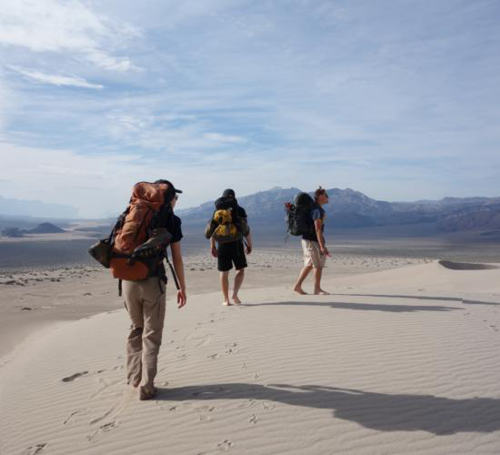

^Original Image^


In [7]:
display(desert)
print('^Original Image^')

# Seam Carve Shrinking Example

Carving Time Remaining: 11.40251855055491 minutes
Carving Time Remaining: 9.626270135243734 minutes
Carving Time Remaining: 9.649736046791077 minutes
Carving Time Remaining: 7.969020088513692 minutes
Carving Time Remaining: 6.593825022379558 minutes
Carving Time Remaining: 5.281950831413269 minutes
Carving Time Remaining: 4.48242990175883 minutes
Carving Time Remaining: 4.038621028264363 minutes
Carving Time Remaining: 2.762889862060547 minutes
Carving Time Remaining: 2.176811615626017 minutes
Carving Time Remaining: 1.453346808751424 minutes
Carving Time Remaining: 0.8157429695129395 minutes
Carving Time Remaining: 0.24207834402720133 minutes


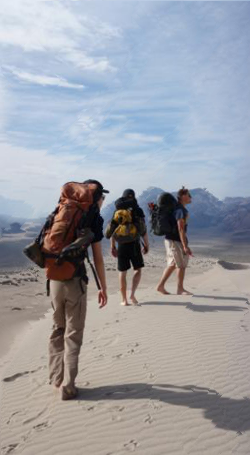

^Carved Image^
Average Energy: 7.664134065934066


In [27]:
cimg, img = seam_carve(desert, 0.5)
display(Image.fromarray(cimg.astype(np.uint8)))
print('^Carved Image^')
print('Average Energy: ' + str(get_average_energy(img)))

# Seam Carve Enlarging Example

Enlarging Stage 1 Time Remaining: 10.031071901321411 minutes
Enlarging Stage 1 Time Remaining: 6.860466082890828 minutes
Enlarging Stage 1 Time Remaining: 5.72898789246877 minutes
Enlarging Stage 1 Time Remaining: 4.272453546524048 minutes
Enlarging Stage 1 Time Remaining: 3.183127482732137 minutes
Enlarging Stage 1 Time Remaining: 2.1410590410232544 minutes
Enlarging Stage 1 Time Remaining: 1.2132346630096436 minutes
Enlarging Stage 1 Time Remaining: 0.3735378185908 minutes
Enlarging Stage 2 Time Remaining: 1.2454736232757568 minutes
Enlarging Stage 2 Time Remaining: 1.5269543329874675 minutes
Enlarging Stage 2 Time Remaining: 1.5074769258499146 minutes
Enlarging Stage 2 Time Remaining: 1.253673791885376 minutes
Enlarging Stage 2 Time Remaining: 0.6771875619888306 minutes
Enlarging Stage 2 Time Remaining: 0.4273847738901774 minutes
Enlarging Stage 2 Time Remaining: 0.424518346786499 minutes
Enlarging Stage 2 Time Remaining: 0.15773320198059082 minutes


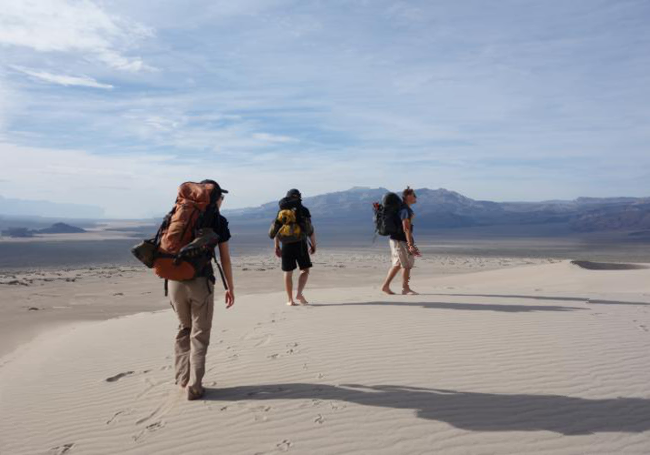

^Enlarged Image^


In [10]:
cimg, img = enlarge(desert, 0.3)
display(Image.fromarray(cimg.astype(np.uint8)))
print('^Enlarged Image^')
print('Average Energy: ' + str(get_average_energy(img)))

# Gradient Visualization Example

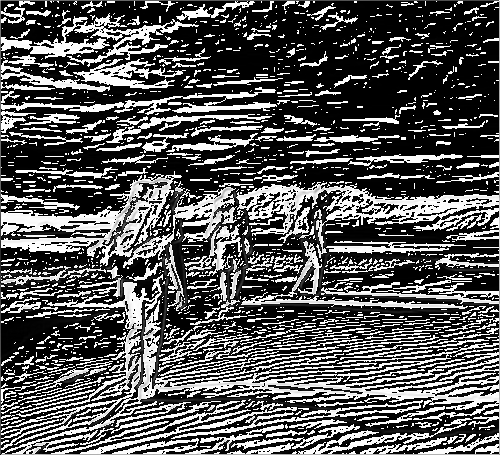

In [15]:
viz_energy(get_energy(np.asarray(desert.convert('L')).astype(np.uint8)))

# Seam Coloring Example


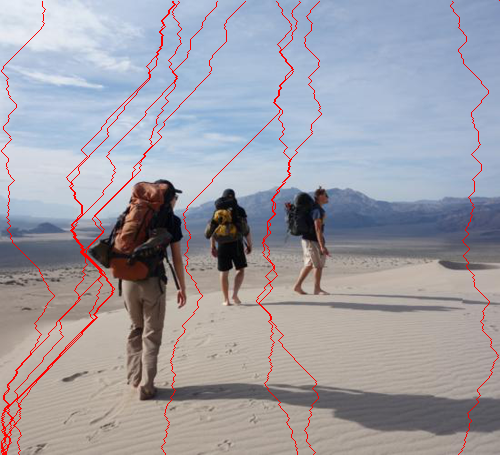

In [12]:
cimg = color_seams_iterate(desert, 0.02)
display(Image.fromarray(cimg.astype(np.uint8)))

# Pixel-Wise Removal Example

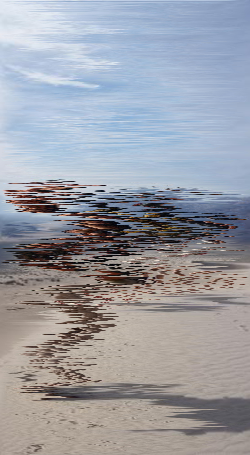

Average Energy: 12.14821098901099


In [25]:
cimg, img = remove_pixels(desert, 0.5)
display(Image.fromarray(cimg.astype(np.uint8)))
print('Average Energy: ' + str(get_average_energy(img)))

# Column Removal Example

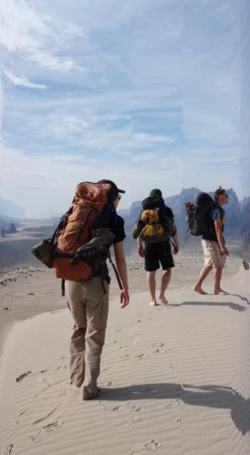

Average Energy: 7.2035824175824175


In [26]:
cimg, img = remove_columns(desert, 0.5)
display(Image.fromarray(cimg.astype(np.uint8)))
print('Average Energy: ' + str(get_average_energy(img)))

# Naive Enlargement Example

Enalarging Time Remaining: 4.590974807739258 minutes
Enalarging Time Remaining: 3.5377252101898193 minutes
Enalarging Time Remaining: 3.71773099899292 minutes
Enalarging Time Remaining: 3.896700620651245 minutes
Enalarging Time Remaining: 3.9342596530914307 minutes
Enalarging Time Remaining: 4.027458429336548 minutes
Enalarging Time Remaining: 6.480236291885376 minutes
Enalarging Time Remaining: 4.2266762256622314 minutes
Enalarging Time Remaining: 4.730263710021973 minutes


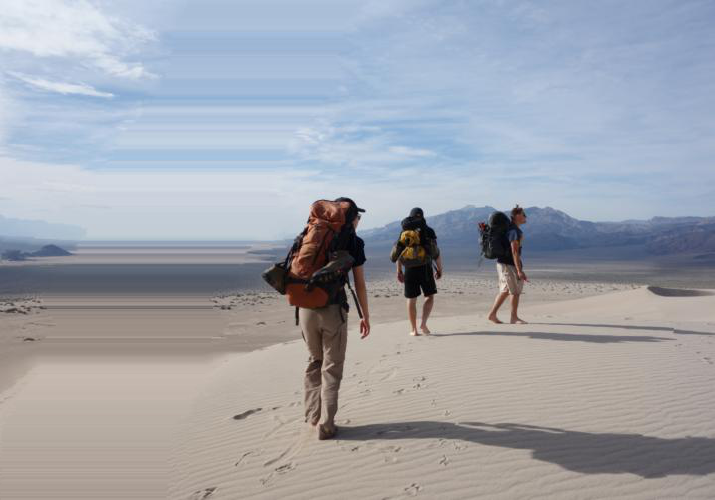

In [ ]:
img = enlarge_naive(desert, h_add=0.3)
display(Image.fromarray(img.astype(np.uint8)))

# Energy Function Comparison

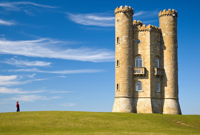

Original Image
Carving Time Remaining: 1.0012890736262003 minutes
Carving Time Remaining: 0.3850857257843018 minutes
Carving Time Remaining: 0.3154370665550232 minutes
Carving Time Remaining: 0.15976189772288005 minutes
Carving Time Remaining: 0.07757763862609864 minutes
Carving Time Remaining: 0.016992183526357015 minutes


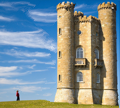

^L1 Energy^
Carving Time Remaining: 0.5449682553609212 minutes
Carving Time Remaining: 0.42507883310317995 minutes
Carving Time Remaining: 0.27459036906560264 minutes
Carving Time Remaining: 0.16125411987304689 minutes
Carving Time Remaining: 0.07977865934371949 minutes
Carving Time Remaining: 0.020957199732462566 minutes


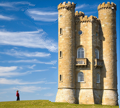

^L2 Energy^
Carving Time Remaining: 0.5671396811803182 minutes
Carving Time Remaining: 0.41133456230163573 minutes
Carving Time Remaining: 0.25585760672887164 minutes
Carving Time Remaining: 0.16276427110036215 minutes
Carving Time Remaining: 0.07909609079360962 minutes
Carving Time Remaining: 0.0219465970993042 minutes


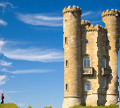

^Harris Corner Detector^
Carving Time Remaining: 0.6347305138905843 minutes
Carving Time Remaining: 0.44497668743133545 minutes
Carving Time Remaining: 0.29436650276184084 minutes
Carving Time Remaining: 0.21162287394205728 minutes
Carving Time Remaining: 0.10408698320388794 minutes
Carving Time Remaining: 0.019550291697184245 minutes


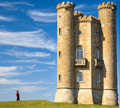

^HOG Scaling^


In [33]:
display(tower)
print('Original Image')

cimg, img = seam_carve(tower, h_reduce=0.4, v_reduce=0.2, energyType=0)
display(Image.fromarray(cimg.astype(np.uint8)))
print('^L1 Energy^')

cimg, img = seam_carve(tower, h_reduce=0.4, v_reduce=0.2, energyType=1)
display(Image.fromarray(cimg.astype(np.uint8)))
print('^L2 Energy^')

cimg, img = seam_carve(tower, h_reduce=0.4, v_reduce=0.2, energyType=2)
display(Image.fromarray(cimg.astype(np.uint8)))
print('^Harris Corner Detector^')

cimg, img = seam_carve(tower, h_reduce=0.4, v_reduce=0.2, energyType=3)
display(Image.fromarray(cimg.astype(np.uint8)))
print('^HOG Scaling^')

# Additional Examples for Presentation

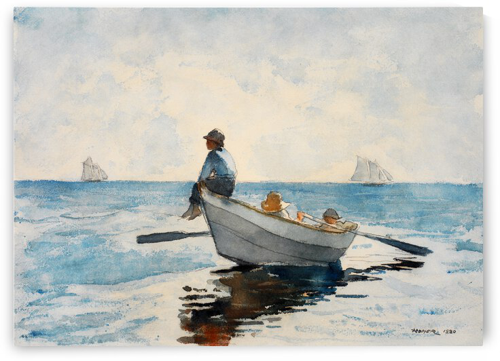

Carving Time Remaining: 13.58165419101715 minutes
Carving Time Remaining: 11.687185875574748 minutes
Carving Time Remaining: 10.250490713119508 minutes
Carving Time Remaining: 9.247627766927083 minutes
Carving Time Remaining: 8.356369924545287 minutes
Carving Time Remaining: 7.656386542320251 minutes
Carving Time Remaining: 6.412098304430644 minutes
Carving Time Remaining: 5.870598451296488 minutes
Carving Time Remaining: 4.540991735458374 minutes
Carving Time Remaining: 4.433850733439128 minutes
Carving Time Remaining: 3.3317031145095823 minutes
Carving Time Remaining: 2.83478581905365 minutes
Carving Time Remaining: 2.147521241505941 minutes
Carving Time Remaining: 2.109759521484375 minutes
Carving Time Remaining: 1.7702698389689127 minutes
Carving Time Remaining: 1.0399371147155763 minutes
Carving Time Remaining: 0.7466255187988281 minutes
Carving Time Remaining: 0.4045079231262207 minutes
Carving Time Remaining: 0.10326519012451171 minutes


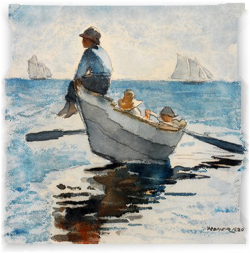

In [34]:
display(row)
rowCarve, _ = seam_carve(row, h_reduce=0.5, v_reduce = 0.3) 
display(Image.fromarray(rowCarve.astype(np.uint8)))
Image.fromarray(rowCarve.astype(np.uint8)).save('rowCarve.jpg')

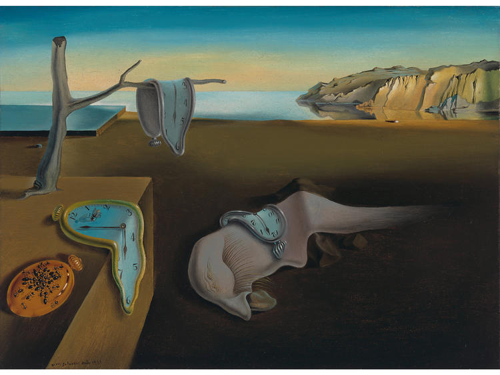

Carving Time Remaining: 6.002890467643738 minutes
Carving Time Remaining: 4.760590314865112 minutes
Carving Time Remaining: 4.150749166806539 minutes
Carving Time Remaining: 3.2689558267593384 minutes
Carving Time Remaining: 2.2447022994359336 minutes
Carving Time Remaining: 1.5858709812164307 minutes
Carving Time Remaining: 0.870000958442688 minutes
Carving Time Remaining: 0.3009016513824463 minutes


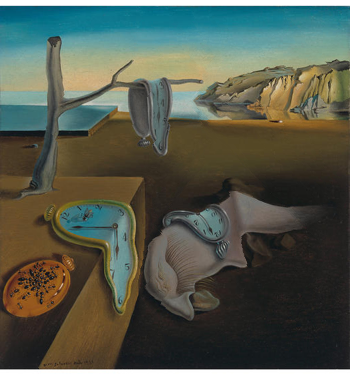

In [ ]:
display(dali)
daliCarve, _ = seam_carve(dali,h_reduce=0.3)
display(Image.fromarray(daliCarve.astype(np.uint8)))
Image.fromarray(daliCarve.astype(np.uint8)).save('daliCarve.jpg')

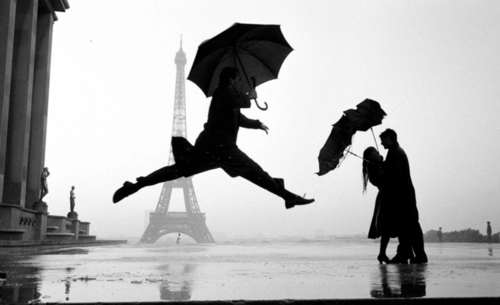

Carving Time Remaining: 4.895201921463013 minutes
Carving Time Remaining: 4.164508819580078 minutes
Carving Time Remaining: 3.197420676549276 minutes
Carving Time Remaining: 2.597062110900879 minutes
Carving Time Remaining: 2.077667156855265 minutes
Carving Time Remaining: 1.2906920909881592 minutes
Carving Time Remaining: 0.7551076412200928 minutes
Carving Time Remaining: 0.24125941594441733 minutes


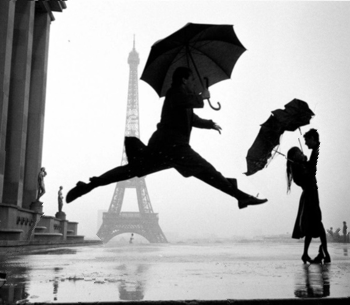

In [ ]:
display(jump)
jumpCarve, _ = seam_carve(jump,h_reduce=0.3)
display(Image.fromarray(jumpCarve.astype(np.uint8)))
Image.fromarray(daliCarve.astype(np.uint8)).save('jumpCarve.jpg')

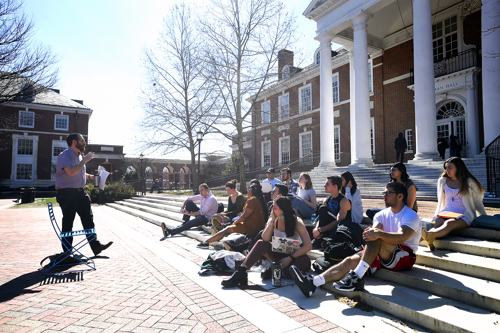

Carving Time Remaining: 5.477877259254456 minutes
Carving Time Remaining: 4.524616916974385 minutes
Carving Time Remaining: 3.398229996363322 minutes
Carving Time Remaining: 2.822739601135254 minutes
Carving Time Remaining: 2.1982128620147705 minutes
Carving Time Remaining: 1.452057957649231 minutes
Carving Time Remaining: 0.7965738773345947 minutes
Carving Time Remaining: 0.259616494178772 minutes


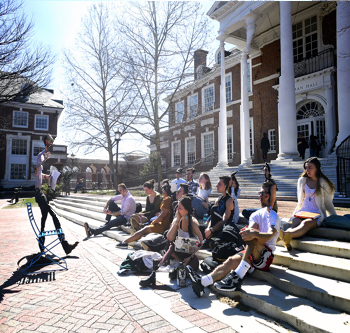

In [ ]:
display(students)
studentsCarve, _ = seam_carve(students,h_reduce=0.3)
display(Image.fromarray(studentsCarve.astype(np.uint8)))
Image.fromarray(daliCarve.astype(np.uint8)).save('studentsCarve.jpg')

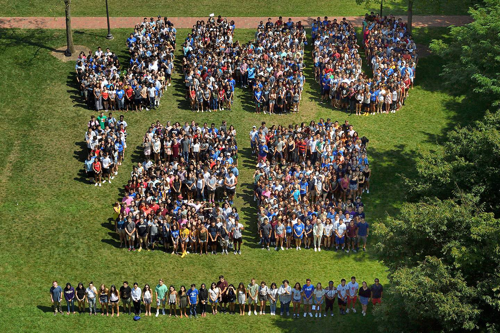

Carving Time Remaining: 8.638094830513001 minutes
Carving Time Remaining: 6.446357444922129 minutes
Carving Time Remaining: 5.34812364578247 minutes
Carving Time Remaining: 4.425200283527374 minutes
Carving Time Remaining: 3.784459114074707 minutes
Carving Time Remaining: 2.6505824446678163 minutes
Carving Time Remaining: 2.1918955365816752 minutes
Carving Time Remaining: 1.476516858736674 minutes
Carving Time Remaining: 1.2524834950764974 minutes
Carving Time Remaining: 0.7063402374585469 minutes
Carving Time Remaining: 0.18577909469604492 minutes


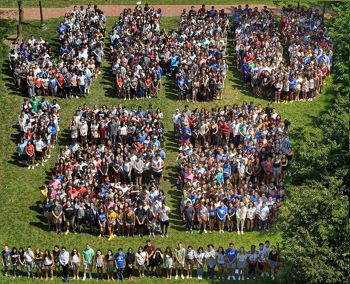

In [ ]:
display(jhu)
jhuCarve, _ = seam_carve(jhu,h_reduce=0.3, v_reduce=0.15)
display(Image.fromarray(jhuCarve.astype(np.uint8)))
Image.fromarray(jhuCarve.astype(np.uint8)).save('jhuCarve.jpg')

In [ ]:
jhu.save('jhuResize.jpg')

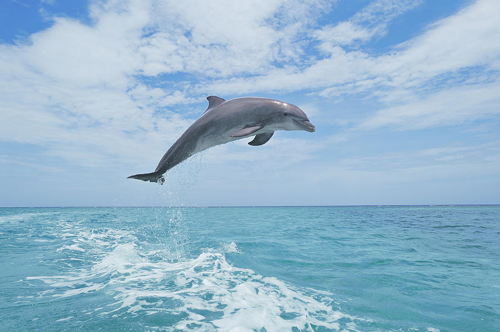

Enlarging Stage 1 Time Remaining: 10.001284877459208 minutes
Enlarging Stage 1 Time Remaining: 8.62466549873352 minutes
Enlarging Stage 1 Time Remaining: 7.631009101867676 minutes
Enlarging Stage 1 Time Remaining: 6.53855303923289 minutes
Enlarging Stage 1 Time Remaining: 5.748125513394673 minutes
Enlarging Stage 1 Time Remaining: 4.664244055747986 minutes
Enlarging Stage 1 Time Remaining: 3.8598719437917075 minutes
Enlarging Stage 1 Time Remaining: 3.0892360607783 minutes
Enlarging Stage 1 Time Remaining: 2.414537787437439 minutes
Enlarging Stage 1 Time Remaining: 1.7432992458343506 minutes
Enlarging Stage 1 Time Remaining: 1.1615663766860962 minutes
Enlarging Stage 1 Time Remaining: 0.6615270376205444 minutes
Enlarging Stage 1 Time Remaining: 0.20454963048299155 minutes
Enlarging Stage 2 Time Remaining: 1.3900707165400188 minutes
Enlarging Stage 2 Time Remaining: 1.2844620148340862 minutes
Enlarging Stage 2 Time Remaining: 2.244733452796936 minutes
Enlarging Stage 2 Time Remaining: 1

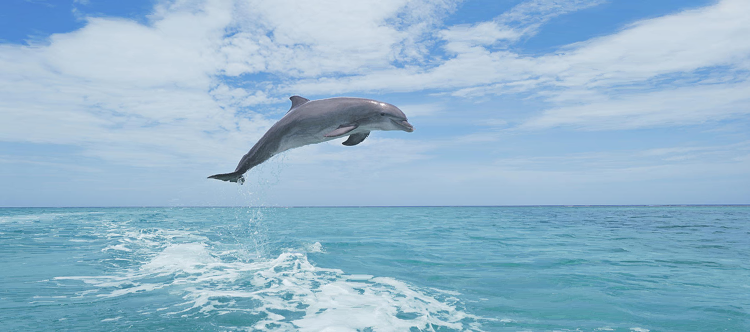

In [ ]:
display(dolphinJ)
dolphinBig, _ = enlarge(dolphinJ,h_add=0.5, v_add=0.0)
display(Image.fromarray(dolphinBig.astype(np.uint8)))
Image.fromarray(dolphinBig.astype(np.uint8)).save('dolphinBig.jpg')

In [ ]:
dolphinJ.save('dolphinJ.jpg')

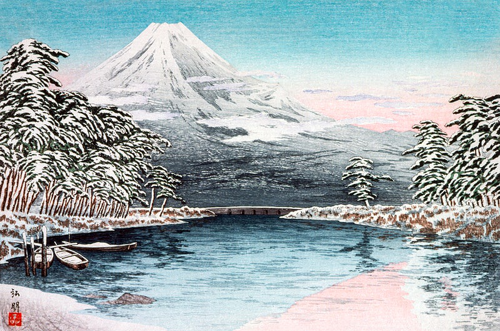

Enlarging Stage 1 Time Remaining: 9.977340698242188 minutes
Enlarging Stage 1 Time Remaining: 8.416324218114218 minutes
Enlarging Stage 1 Time Remaining: 7.537221908569336 minutes
Enlarging Stage 1 Time Remaining: 6.669849197069804 minutes
Enlarging Stage 1 Time Remaining: 5.720654845237732 minutes
Enlarging Stage 1 Time Remaining: 4.627916216850281 minutes
Enlarging Stage 1 Time Remaining: 3.9696479638417563 minutes
Enlarging Stage 1 Time Remaining: 3.122339884440104 minutes
Enlarging Stage 1 Time Remaining: 2.413833975791931 minutes
Enlarging Stage 1 Time Remaining: 1.7721987167994182 minutes
Enlarging Stage 1 Time Remaining: 1.1332736412684123 minutes
Enlarging Stage 1 Time Remaining: 0.6636751890182495 minutes
Enlarging Stage 1 Time Remaining: 0.2043592929840088 minutes
Enlarging Stage 2 Time Remaining: 2.4136006832122803 minutes
Enlarging Stage 2 Time Remaining: 2.1944215297698975 minutes
Enlarging Stage 2 Time Remaining: 1.7194143533706665 minutes
Enlarging Stage 2 Time Remaining

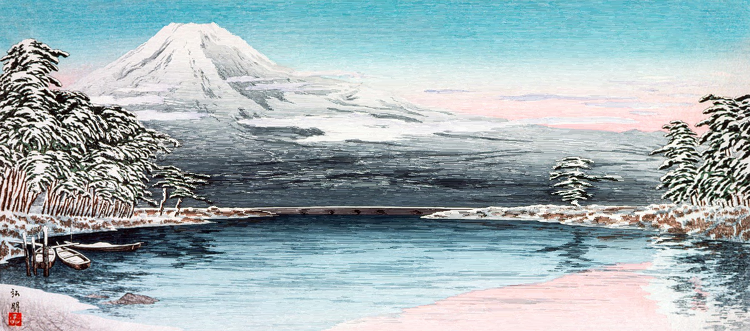

AttributeError: ignored

In [ ]:
display(pond)
pondBig, _ = enlarge(pond,h_add=0.5, v_add=0.0)
display(Image.fromarray(pondBig.astype(np.uint8)))
Image.fromarray(pondBig.astype(np.uint8)).save('pondBig.jpg')


In [ ]:
pond.save('pond.jpg')

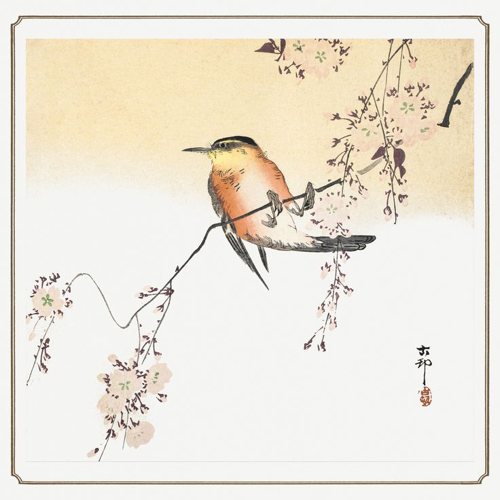

Carving Time Remaining: 7.9454874992370605 minutes
Carving Time Remaining: 6.053305904070537 minutes
Carving Time Remaining: 5.157697677612305 minutes
Carving Time Remaining: 4.033787369728088 minutes
Carving Time Remaining: 2.979412317276001 minutes
Carving Time Remaining: 1.9705851872762044 minutes
Carving Time Remaining: 1.1156967878341675 minutes
Carving Time Remaining: 0.37451664606730145 minutes


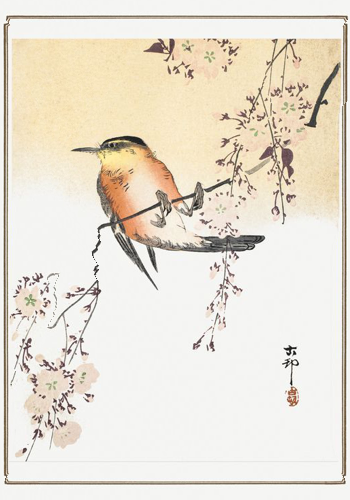

In [ ]:
display(bird)
birdCarve, _ = seam_carve(bird,h_reduce=0.3)
display(Image.fromarray(birdCarve.astype(np.uint8)))
Image.fromarray(birdCarve.astype(np.uint8)).save('birdCarve.jpg')

In [ ]:
bird.save('bird.jpg')

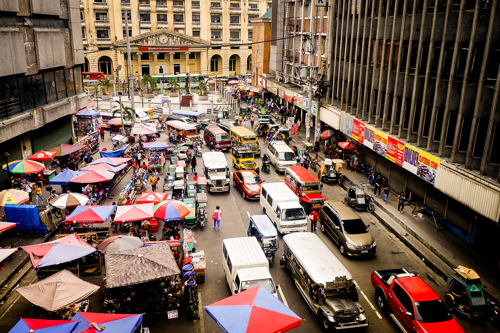

Carving Time Remaining: 8.528823653856913 minutes
Carving Time Remaining: 7.5771903196970625 minutes
Carving Time Remaining: 6.671285033226013 minutes
Carving Time Remaining: 5.982878049214681 minutes
Carving Time Remaining: 4.866353948911031 minutes
Carving Time Remaining: 4.145402312278748 minutes
Carving Time Remaining: 3.350244720776876 minutes
Carving Time Remaining: 2.689080834388733 minutes
Carving Time Remaining: 2.0769885778427124 minutes
Carving Time Remaining: 1.5257372458775837 minutes
Carving Time Remaining: 1.0429573059082031 minutes
Carving Time Remaining: 0.5671514272689819 minutes
Carving Time Remaining: 0.18176118532816568 minutes


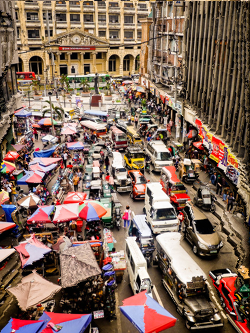

In [ ]:
display(city)
cityCarve, _ = seam_carve(city,h_reduce=0.5)
display(Image.fromarray(cityCarve.astype(np.uint8)))
Image.fromarray(cityCarve.astype(np.uint8)).save('cityCarve.jpg')

In [ ]:
city.save('city.jpg')